In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



## **Load** **the** **Data**

In [4]:
# Load movie info
movies = pd.read_csv("rt.movie_info (2).tsv.gz", sep="\t", encoding="utf-8")

# Load reviews
reviews = pd.read_csv("rt.reviews.tsv.gz", sep="\t", encoding="latin-1")

# Preview
print(movies.head())
print(reviews.head())

   id                                           synopsis rating  \
0   1  This gritty, fast-paced, and innovative police...      R   
1   3  New York City, not-too-distant-future: Eric Pa...      R   
2   5  Illeana Douglas delivers a superb performance ...      R   
3   6  Michael Douglas runs afoul of a treacherous su...      R   
4   7                                                NaN     NR   

                                 genre          director  \
0  Action and Adventure|Classics|Drama  William Friedkin   
1    Drama|Science Fiction and Fantasy  David Cronenberg   
2    Drama|Musical and Performing Arts    Allison Anders   
3           Drama|Mystery and Suspense    Barry Levinson   
4                        Drama|Romance    Rodney Bennett   

                            writer  theater_date      dvd_date currency  \
0                   Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN   
1     David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   
2          

# **Analyze** **Which** **Genres** **Perform** **Best**

Average Scores by Genre

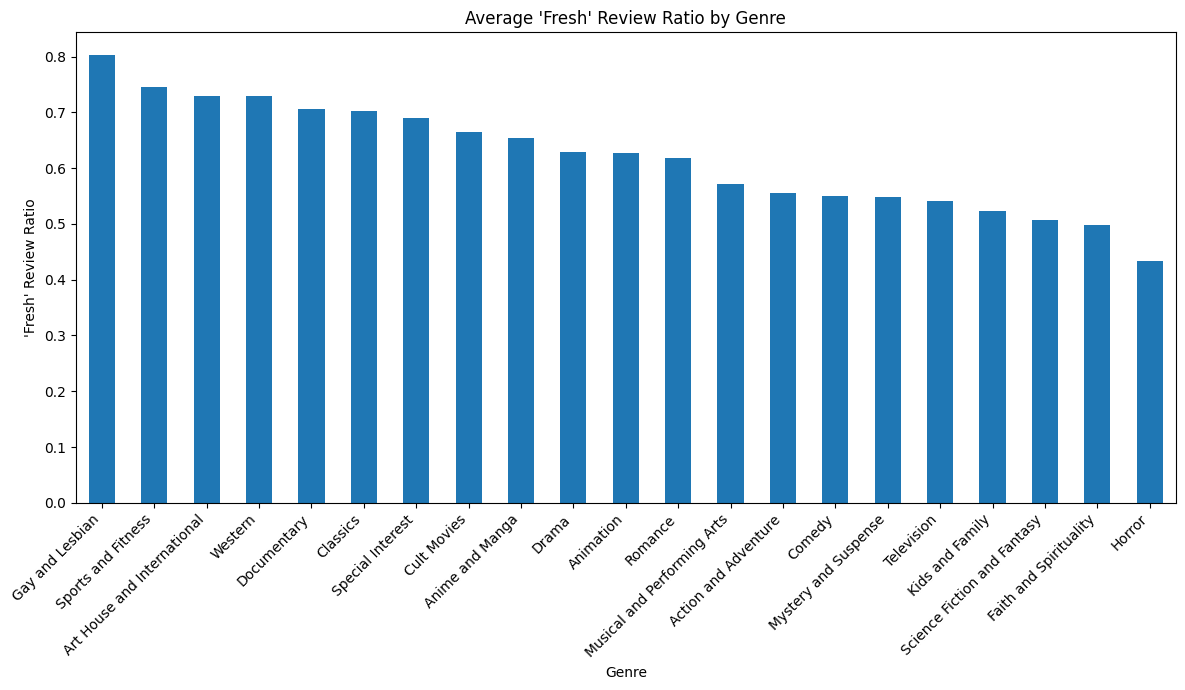

Top 10 Genres by Average 'Fresh' Review Ratio:
genre
Gay and Lesbian                0.803571
Sports and Fitness             0.746182
Art House and International    0.730430
Western                        0.729260
Documentary                    0.705401
Classics                       0.703107
Special Interest               0.690382
Cult Movies                    0.665633
Anime and Manga                0.655000
Drama                          0.629465
Name: fresh_ratio, dtype: float64


In [5]:
# Calculate a 'fresh_ratio' from the reviews DataFrame as a proxy for sentiment
review_sentiment = reviews.groupby('id')['fresh'].value_counts(normalize=True).unstack(fill_value=0)
# Rename 'fresh' column to 'fresh_ratio' for clarity
review_sentiment = review_sentiment.rename(columns={'fresh': 'fresh_ratio'})

# Merge the review sentiment with the movies DataFrame
movies_with_sentiment = movies.merge(review_sentiment[['fresh_ratio']], left_on='id', right_index=True, how='inner')

# Handle rows where genre might be missing or multiple genres are listed
# For simplicity, we will split genres and explode the dataframe, then group
movies_with_sentiment['genre'] = movies_with_sentiment['genre'].str.split('|')
movies_with_sentiment_exploded = movies_with_sentiment.explode('genre')

# Calculate the average fresh_ratio by genre
genre_sentiment = movies_with_sentiment_exploded.groupby("genre")["fresh_ratio"].mean().sort_values(ascending=False)

# Visualize the average fresh_ratio by genre
plt.figure(figsize=(12, 7))
genre_sentiment.plot(kind="bar")
plt.title("Average 'Fresh' Review Ratio by Genre")
plt.ylabel("'Fresh' Review Ratio")
plt.xlabel("Genre")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the top 10 genres by average fresh ratio
print("Top 10 Genres by Average 'Fresh' Review Ratio:")
print(genre_sentiment.head(10))

In [6]:
# Average scores by genre (as proxy for market performance)
# Using 'fresh_ratio' as a proxy for sentiment since 'audience_score' and 'critics_score' are not available
genre_sentiment_analysis = movies_with_sentiment_exploded.groupby("genre")["fresh_ratio"].mean().reset_index()

# Calculate an overall average 'fresh_ratio' to compare against
overall_fresh_ratio_avg = movies_with_sentiment_exploded["fresh_ratio"].mean()

# Add a 'risk' proxy (difference from overall average 'fresh_ratio')
genre_sentiment_analysis["risk_gap"] = (genre_sentiment_analysis["fresh_ratio"] - overall_fresh_ratio_avg).abs()

# Sort by 'fresh_ratio' (genres with higher sentiment)
genre_sentiment_analysis.sort_values("fresh_ratio", ascending=False, inplace=True)

# Display the results
print("Genre Sentiment Analysis based on 'Fresh' Review Ratio:")
display(genre_sentiment_analysis.head(10))

Genre Sentiment Analysis based on 'Fresh' Review Ratio:


,genre,fresh_ratio,risk_gap
10,Gay and Lesbian,0.803571,0.206226
18,Sports and Fitness,0.746182,0.148837
3,Art House and International,0.730430,0.133084
20,Western,0.729260,0.131915
7,Documentary,0.705401,0.108056
4,Classics,0.703107,0.105762
17,Special Interest,0.690382,0.093037
6,Cult Movies,0.665633,0.068288
2,Anime and Manga,0.655000,0.057655
8,Drama,0.629465,0.032120


# **Visualisation**

**Genre** **Success** **vs** **Risk**

/tmp/ipython-input-3064444475.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_sentiment_analysis.head(10), x="fresh_ratio", y="genre", palette="mako")


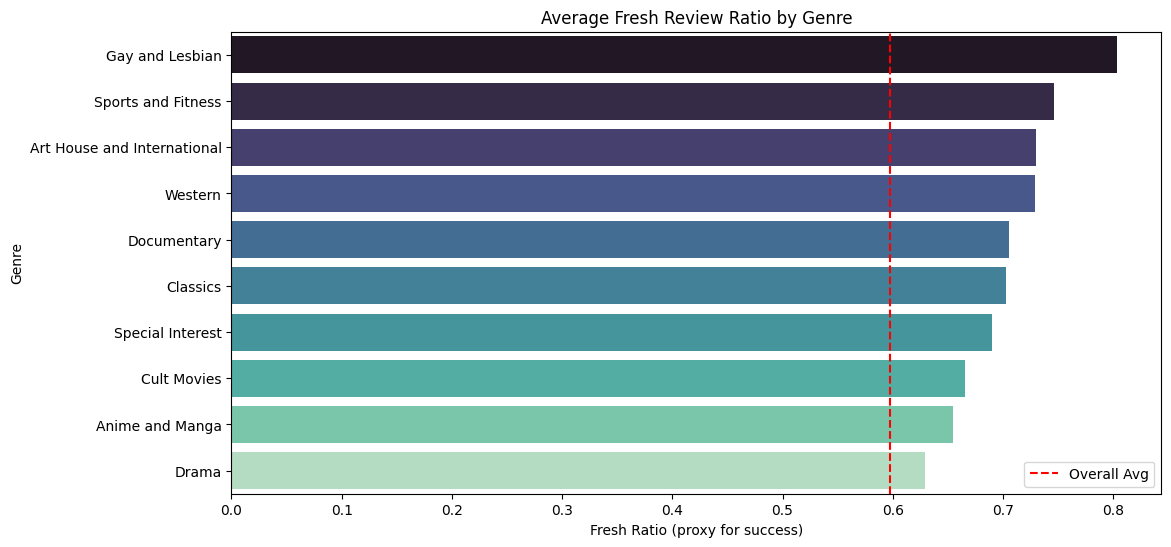

In [7]:
plt.figure(figsize=(12,6))
sns.barplot(data=genre_sentiment_analysis.head(10), x="fresh_ratio", y="genre", palette="mako")
plt.axvline(overall_fresh_ratio_avg, color="red", linestyle="--", label="Overall Avg")
plt.title("Average Fresh Review Ratio by Genre")
plt.xlabel("Fresh Ratio (proxy for success)")
plt.ylabel("Genre")
plt.legend()
plt.show()


**Risk** **vs** **Return**

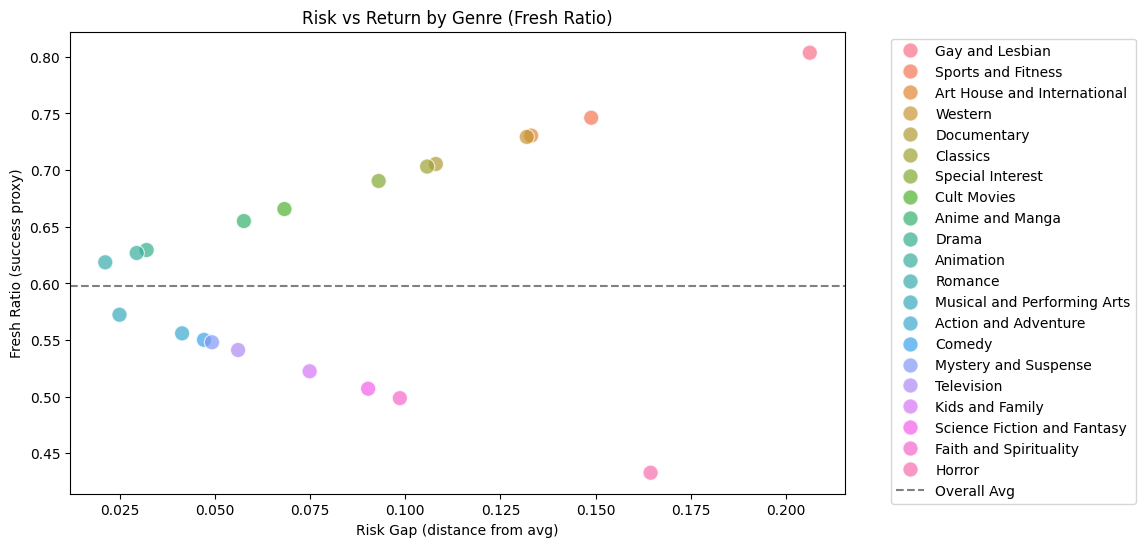

In [8]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=genre_sentiment_analysis,
                x="risk_gap",
                y="fresh_ratio",
                hue="genre",
                s=120, alpha=0.7)

plt.title("Risk vs Return by Genre (Fresh Ratio)")
plt.xlabel("Risk Gap (distance from avg)")
plt.ylabel("Fresh Ratio (success proxy)")
plt.axhline(overall_fresh_ratio_avg, color="gray", linestyle="--", label="Overall Avg")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# **Financial** **Insights**

In [10]:
def generate_financial_insights(df, overall_avg):
    insights = []
    for _, row in df.iterrows():
        genre = row["genre"]
        ratio = row["fresh_ratio"]
        risk = row["risk_gap"]

        if ratio > overall_avg and risk < 0.05:
            insights.append(f"✅ {genre}: Strong performer with above-average sentiment ({ratio:.2f}), low risk ({risk:.2f}). Safe investment for steady box office returns.")
        elif ratio > overall_avg and risk >= 0.05:
            insights.append(f"📈 {genre}: High upside with strong sentiment ({ratio:.2f}), but higher volatility ({risk:.2f}). Potential blockbuster genre if marketed well.")
        elif ratio < overall_avg and risk < 0.05:
            insights.append(f"⚖️ {genre}: Stable but underperforming sentiment ({ratio:.2f}). Safer bet but may yield modest returns — suitable for niche audiences.")
        else:
            insights.append(f"⚠️ {genre}: Below-average sentiment ({ratio:.2f}) with higher risk ({risk:.2f}). Consider only for strategic diversification or low-budget projects.")
    return insights

# Generate insights for the top 10 genres
financial_insights = generate_financial_insights(genre_sentiment_analysis.head(10), overall_fresh_ratio_avg)
print("\n--- Financial Insights by Genre ---\n")
for insight in financial_insights:
    print(insight)



--- Financial Insights by Genre ---

📈 Gay and Lesbian: High upside with strong sentiment (0.80), but higher volatility (0.21). Potential blockbuster genre if marketed well.
📈 Sports and Fitness: High upside with strong sentiment (0.75), but higher volatility (0.15). Potential blockbuster genre if marketed well.
📈 Art House and International: High upside with strong sentiment (0.73), but higher volatility (0.13). Potential blockbuster genre if marketed well.
📈 Western: High upside with strong sentiment (0.73), but higher volatility (0.13). Potential blockbuster genre if marketed well.
📈 Documentary: High upside with strong sentiment (0.71), but higher volatility (0.11). Potential blockbuster genre if marketed well.
📈 Classics: High upside with strong sentiment (0.70), but higher volatility (0.11). Potential blockbuster genre if marketed well.
📈 Special Interest: High upside with strong sentiment (0.69), but higher volatility (0.09). Potential blockbuster genre if marketed well.
📈 Cult